In [1]:

from network import transformNet
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet,DiscriminatorNet_feature
from functional import noise
#from train import train,eval_generate
import resnet


import invresnet
import matplotlib.pylab as plt

from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim

In [2]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:

%load_ext autoreload
%autoreload 2

In [4]:
train_load,test_load=batchfy(batch_size=64)

In [5]:
show_img=iter(train_load)

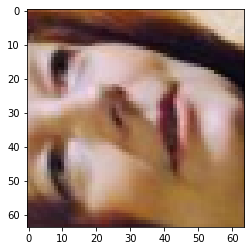

In [6]:
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [7]:
len(train_load)

2771

In [8]:
Encoder=resnet.resnet18()
Encoder.to(device)

Decoder=invresnet.invresnet18()
Decoder.to(device)

Generator=GeneratorNet(Encoder,Decoder)
Generator.to(device)
Discriminator_reconstruct=DiscriminatorNet_reconstruction(3,64)
Discriminator_reconstruct.to(device)

Discriminator_feature=DiscriminatorNet_feature()
Discriminator_feature.to(device)
print("model_loaded")

debug=torch.randn((1,99))
debug.to(device)
Decoder(debug).shape

model_loaded


torch.Size([1, 3, 64, 64])

In [25]:
dr_optimizer = optim.Adam(Discriminator_reconstruct.parameters(), lr=0.00005, betas=(0.5, 0.999))
df_optimizer = optim.Adam(Discriminator_feature.parameters(), lr=0.00005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(Generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
e_optimizer = optim.Adam(Encoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(Decoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
#print("modules Loaded")
num_epochs=40

In [26]:
import time
from torchvision import transforms, utils

In [29]:
def real_data_target(size):
    data = torch.ones(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = torch.zeros(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def real_feature_target(size):
    data = torch.ones(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_feature_target(size):
    data = torch.zeros(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def reconstruction_loss(optimizer,real_data,Generator):
    reconstruction=Generator(real_data)
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(real_data,reconstruction)*0.9
    error_recons.backward()
    optimizer.step()
    return error_recons
def adv_feature_loss(minimizing,real_feature,fake_feature,Discriminator,optimizer1,optimizer2):
    loss=nn.BCELoss()
    if minimizing:
        optimizer1.zero_grad()
        prediction_real = Discriminator(real_feature)
        error_real = loss(prediction_real, real_feature_target(real_feature.size(0)))
        error_real.backward()   
        
        prediction_fake = Discriminator(fake_feature)
        error_fake = loss(prediction_fake, fake_feature_target(real_feature.size(0)))
        error_fake.backward()
        total_error=error_real+error_fake
        optimizer1.step()    
        return error_real+error_fake
    else:
        optimizer2.zero_grad()
        prediction_fake=Discriminator(fake_feature)
        error_fake = loss(prediction_fake, real_feature_target(real_feature.size(0)))
        error_fake.backward()
        optimizer2.step()    
        return error_fake


def adv_img_loss(minimizing,real_data,fake_data,Discriminator,optimizer1,optimizer2):
    loss = nn.BCELoss()
    def dloss_calc_adv(optimizer, real_data, fake_data,Discriminator):
        
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake
    def gloss_calc_adv(optimizer, real_data,fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_fake=Discriminator(fake_data_target)
        error_fake = loss(prediction_fake, real_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
       
    if minimizing:
        return dloss_calc_adv(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc_adv(optimizer2,real_data,fake_data,Discriminator)
    
    
def gen_image_loss(minimizing,real_data, fake_data,Discriminator, optimizer1,optimizer2):
    def dloss_calc(optimizer, real_data, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake, prediction_real, prediction_fake
    def gloss_calc(optimizer, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_data_target(prediction.size(0)))
        error.backward()
        optimizer.step()
        return error
    
    loss = nn.BCELoss()
        
    if minimizing:
        return dloss_calc(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc(optimizer2,fake_data,Discriminator)

def noise_vector(size):
    n = torch.randn(size,99)
    if torch.cuda.is_available(): return n.cuda() 
    return n

def eval_generate(Decoder,num_images):
    Decoder.eval()
    noi_input=noise_vector(num_images)
    output=Decoder(noi_input)
    output=output.detach().cpu()
    plt.figure(figsize=(16, 16))
    grid_border_size = 2
    grid = utils.make_grid(output)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def train(num_epochs,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load):
    t_start = time.time()
    duration_avg = 0.0
    Encoder.train()
    Decoder.train()
    Generator.train()
    Discriminator_reconstruct.train()
    Discriminator_feature.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):        
 
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            noi = noise_vector(real_images.size(0))

            # 1-1.Train DiscriminatorX with img
            fake_data = Decoder(noi).detach()
            d_error, d_pred_real, d_pred_fake =gen_image_loss(True,real_images.float(), 
                                                              fake_data,Discriminator_reconstruct,
                                                              dr_optimizer,d_optimizer)
            # Train 1-2 GeneratorX
            fake_data = Decoder(noi)#noise(real_batch.size(0)))
            g_error = gen_image_loss(False, real_images.float(), fake_data,
                                    Discriminator_reconstruct,
                                    dr_optimizer,d_optimizer)

            #2 Train DiscriminatorZ
            real_feature=Encoder(real_images.float()).detach()
            df_error_adv=adv_feature_loss(True,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            real_feature=Encoder(real_images.float())
            en_error_adv=adv_feature_loss(False,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            #3-1 Train DiscriminatorX_adv
            
            fake_data=Generator(real_images.float()).detach()
            d_error1=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            #3-2 Train GeneratorX_adv
            fake_data=Generator(real_images.float())
            g_error2=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            # 4. Train Reconstruction
            
            recons_loss=reconstruction_loss(g_optimizer,real_images.float(),Generator)
            
            
            # Display Progress
            if (batch_i) % 150 == 0:
                print("Batch: ", batch_i)
                print("1:Discriminator_Error: ", d_error.item()," Generator_Error: ", g_error.item()," Recons_Error: ", recons_loss.item())
                print("2:Feature Discriminator Error: ",df_error_adv.item(),"Encoder Error: ", en_error_adv.item())
                print("3 Discriminator_adv_error", d_error1.item(), "Generator_error: ", g_error2.item())
            
    
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        torch.save(Encoder,'Encoder_64batch.h')
        torch.save(Decoder,'Decoder_64batch.h')
        torch.save(Discriminator_feature,'Discriminator_feature_64batch.h')
        torch.save(Discriminator_reconstruct,'Discriminator_reconstruct_64batch.h')
        eval_generate(Decoder,8)
        

Epoch: 0
Batch:  0
1:Discriminator_Error:  1.3647533655166626  Generator_Error:  0.7268292903900146  Recons_Error:  0.4476111829280853
2:Feature Discriminator Error:  1.454769492149353 Encoder Error:  0.6978426575660706
3 Discriminator_adv_error 1.3324997425079346 Generator_error:  1.3228974342346191
Batch:  150
1:Discriminator_Error:  1.2952382564544678  Generator_Error:  0.6108510494232178  Recons_Error:  0.20902442932128906
2:Feature Discriminator Error:  1.391573190689087 Encoder Error:  0.6667749285697937
3 Discriminator_adv_error 0.8638527393341064 Generator_error:  0.8594735860824585
Batch:  300
1:Discriminator_Error:  1.4171619415283203  Generator_Error:  0.5563458800315857  Recons_Error:  0.1909133493900299
2:Feature Discriminator Error:  1.4600813388824463 Encoder Error:  0.6516565680503845
3 Discriminator_adv_error 0.9163268804550171 Generator_error:  0.9042924642562866
Batch:  450
1:Discriminator_Error:  1.4244996309280396  Generator_Error:  0.5282440185546875  Recons_Error

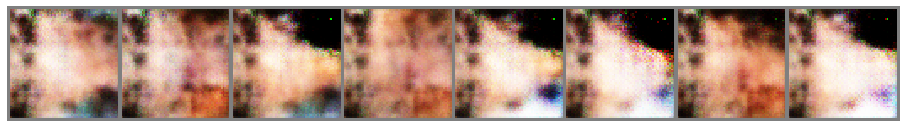

Epoch: 1
Batch:  0
1:Discriminator_Error:  1.307386875152588  Generator_Error:  0.557065486907959  Recons_Error:  0.1795802116394043
2:Feature Discriminator Error:  1.4010858535766602 Encoder Error:  0.707810640335083
3 Discriminator_adv_error 0.778488039970398 Generator_error:  0.7096798419952393
Batch:  150
1:Discriminator_Error:  0.1544310599565506  Generator_Error:  2.8324124813079834  Recons_Error:  0.83416348695755
2:Feature Discriminator Error:  1.3915029764175415 Encoder Error:  0.7114456295967102
3 Discriminator_adv_error 0.15383946895599365 Generator_error:  0.15489789843559265
Batch:  300
1:Discriminator_Error:  0.10934671759605408  Generator_Error:  3.0820555686950684  Recons_Error:  0.8678017854690552
2:Feature Discriminator Error:  1.397688627243042 Encoder Error:  0.7324575185775757
3 Discriminator_adv_error 0.10896273702383041 Generator_error:  0.1079733818769455
Batch:  450
1:Discriminator_Error:  1.3181127309799194  Generator_Error:  0.7486687898635864  Recons_Error: 

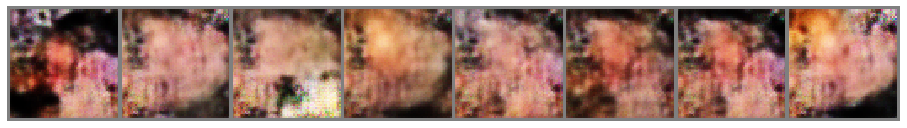

Epoch: 2
Batch:  0
1:Discriminator_Error:  1.4514309167861938  Generator_Error:  0.501923680305481  Recons_Error:  0.12005406618118286
2:Feature Discriminator Error:  1.3943899869918823 Encoder Error:  0.7094489932060242
3 Discriminator_adv_error 0.500093400478363 Generator_error:  0.43117183446884155
Batch:  150
1:Discriminator_Error:  1.4773858785629272  Generator_Error:  0.44760948419570923  Recons_Error:  0.10934703052043915
2:Feature Discriminator Error:  1.389972448348999 Encoder Error:  0.6933279633522034
3 Discriminator_adv_error 0.3662881553173065 Generator_error:  0.35884103178977966
Batch:  300
1:Discriminator_Error:  1.4874924421310425  Generator_Error:  0.45158541202545166  Recons_Error:  0.10465551167726517
2:Feature Discriminator Error:  1.3929307460784912 Encoder Error:  0.6999610662460327
3 Discriminator_adv_error 0.4084226191043854 Generator_error:  0.39095938205718994
Batch:  450
1:Discriminator_Error:  1.4871795177459717  Generator_Error:  0.5747567415237427  Recons

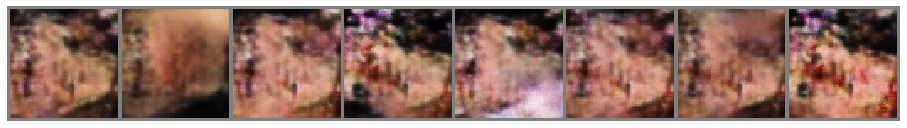

Epoch: 3
Batch:  0
1:Discriminator_Error:  1.58161199092865  Generator_Error:  0.5116832256317139  Recons_Error:  0.11009404808282852
2:Feature Discriminator Error:  1.3895130157470703 Encoder Error:  0.7041373252868652
3 Discriminator_adv_error 0.510658860206604 Generator_error:  0.4587760269641876
Batch:  150
1:Discriminator_Error:  1.4624156951904297  Generator_Error:  0.4242018759250641  Recons_Error:  0.11033026874065399
2:Feature Discriminator Error:  1.3959507942199707 Encoder Error:  0.6915465593338013
3 Discriminator_adv_error 0.32116395235061646 Generator_error:  0.31694257259368896
Batch:  300
1:Discriminator_Error:  1.567009687423706  Generator_Error:  0.3789547085762024  Recons_Error:  0.10312188416719437
2:Feature Discriminator Error:  1.3930718898773193 Encoder Error:  0.7046732902526855
3 Discriminator_adv_error 0.3219342529773712 Generator_error:  0.31691476702690125
Batch:  450
1:Discriminator_Error:  1.476453423500061  Generator_Error:  0.5933571457862854  Recons_Err

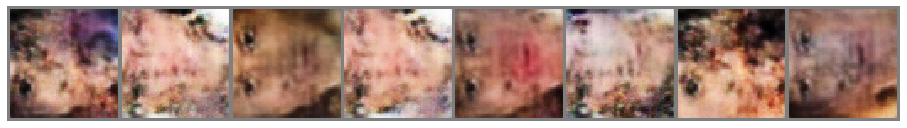

Epoch: 4
Batch:  0
1:Discriminator_Error:  1.5455549955368042  Generator_Error:  0.42847636342048645  Recons_Error:  0.10497920960187912
2:Feature Discriminator Error:  1.3890432119369507 Encoder Error:  0.6951779127120972
3 Discriminator_adv_error 0.3612046241760254 Generator_error:  0.3508716821670532
Batch:  150
1:Discriminator_Error:  1.5423429012298584  Generator_Error:  0.40582671761512756  Recons_Error:  0.09557213634252548
2:Feature Discriminator Error:  1.380568027496338 Encoder Error:  0.6936901211738586
3 Discriminator_adv_error 0.3112082779407501 Generator_error:  0.30626368522644043
Batch:  300
1:Discriminator_Error:  1.9079138040542603  Generator_Error:  0.3808239698410034  Recons_Error:  0.09954623878002167
2:Feature Discriminator Error:  1.3903239965438843 Encoder Error:  0.685588538646698
3 Discriminator_adv_error 0.7141126394271851 Generator_error:  0.8625571727752686
Batch:  450
1:Discriminator_Error:  1.6221059560775757  Generator_Error:  0.36771470308303833  Recons

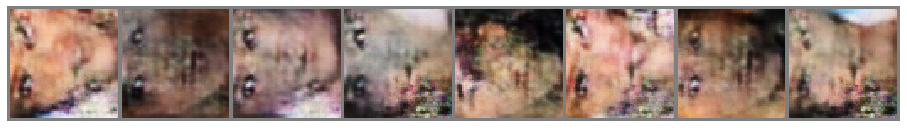

Epoch: 5
Batch:  0
1:Discriminator_Error:  1.6207550764083862  Generator_Error:  0.5170313119888306  Recons_Error:  0.10286471992731094
2:Feature Discriminator Error:  1.3891702890396118 Encoder Error:  0.6892846822738647
3 Discriminator_adv_error 0.36943888664245605 Generator_error:  0.3151589632034302
Batch:  150
1:Discriminator_Error:  1.6067824363708496  Generator_Error:  0.38029950857162476  Recons_Error:  0.09124010801315308
2:Feature Discriminator Error:  1.3877253532409668 Encoder Error:  0.6984302997589111
3 Discriminator_adv_error 0.35879361629486084 Generator_error:  0.34942179918289185
Batch:  300
1:Discriminator_Error:  1.5705931186676025  Generator_Error:  0.3826901912689209  Recons_Error:  0.09489281475543976
2:Feature Discriminator Error:  1.385596752166748 Encoder Error:  0.6989829540252686
3 Discriminator_adv_error 0.31041964888572693 Generator_error:  0.30331310629844666
Batch:  450
1:Discriminator_Error:  1.5048134326934814  Generator_Error:  0.4860510230064392  Rec

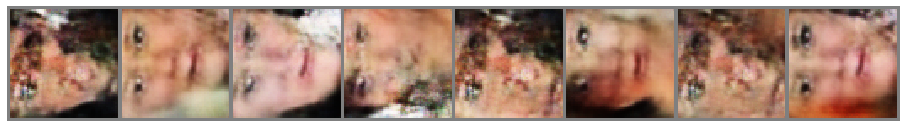

Epoch: 6
Batch:  0
1:Discriminator_Error:  1.5903849601745605  Generator_Error:  0.40474244952201843  Recons_Error:  0.09291024506092072
2:Feature Discriminator Error:  1.386387586593628 Encoder Error:  0.7030534148216248
3 Discriminator_adv_error 0.356771856546402 Generator_error:  0.3346283435821533
Batch:  150
1:Discriminator_Error:  1.6901013851165771  Generator_Error:  0.3502253293991089  Recons_Error:  0.08761732280254364
2:Feature Discriminator Error:  1.38462495803833 Encoder Error:  0.6987528800964355
3 Discriminator_adv_error 0.36792823672294617 Generator_error:  0.34426096081733704
Batch:  300
1:Discriminator_Error:  1.6189188957214355  Generator_Error:  0.3519427180290222  Recons_Error:  0.08803723007440567
2:Feature Discriminator Error:  1.3859522342681885 Encoder Error:  0.6975362300872803
3 Discriminator_adv_error 0.3325391411781311 Generator_error:  0.3273651599884033
Batch:  450
1:Discriminator_Error:  1.38779878616333  Generator_Error:  0.4977250099182129  Recons_Erro

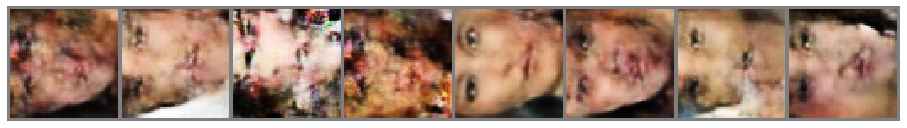

Epoch: 7
Batch:  0
1:Discriminator_Error:  1.5733373165130615  Generator_Error:  0.3818328380584717  Recons_Error:  0.08890905976295471
2:Feature Discriminator Error:  1.387798547744751 Encoder Error:  0.6877318620681763
3 Discriminator_adv_error 0.35221290588378906 Generator_error:  0.34343162178993225
Batch:  150
1:Discriminator_Error:  1.5225145816802979  Generator_Error:  0.4121657609939575  Recons_Error:  0.09210562705993652
2:Feature Discriminator Error:  1.3857669830322266 Encoder Error:  0.6961450576782227
3 Discriminator_adv_error 0.3165416419506073 Generator_error:  0.3117331564426422
Batch:  300
1:Discriminator_Error:  1.5666981935501099  Generator_Error:  0.3638536334037781  Recons_Error:  0.0880553275346756
2:Feature Discriminator Error:  1.3895896673202515 Encoder Error:  0.6962412595748901
3 Discriminator_adv_error 0.3164861500263214 Generator_error:  0.30996188521385193
Batch:  450
1:Discriminator_Error:  1.6007634401321411  Generator_Error:  0.36331498622894287  Recons

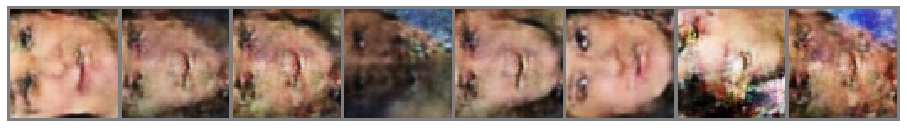

Epoch: 8
Batch:  0
1:Discriminator_Error:  1.5677974224090576  Generator_Error:  0.37747088074684143  Recons_Error:  0.08476037532091141
2:Feature Discriminator Error:  1.386157512664795 Encoder Error:  0.6950293183326721
3 Discriminator_adv_error 0.3046710193157196 Generator_error:  0.3026619553565979
Batch:  150
1:Discriminator_Error:  1.7065614461898804  Generator_Error:  0.3379485011100769  Recons_Error:  0.08528834581375122
2:Feature Discriminator Error:  1.38442063331604 Encoder Error:  0.699103593826294
3 Discriminator_adv_error 0.34448695182800293 Generator_error:  0.3243426978588104
Batch:  300
1:Discriminator_Error:  1.6695220470428467  Generator_Error:  0.3939015865325928  Recons_Error:  0.08325739204883575
2:Feature Discriminator Error:  1.38434898853302 Encoder Error:  0.6981742978096008
3 Discriminator_adv_error 0.3621160686016083 Generator_error:  0.3466590344905853
Batch:  450
1:Discriminator_Error:  1.5258618593215942  Generator_Error:  0.3919070065021515  Recons_Error

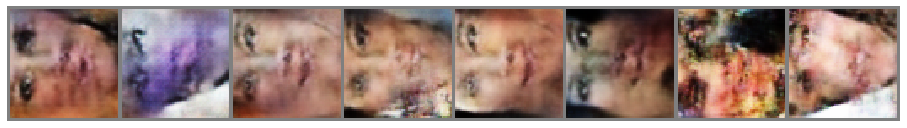

Epoch: 9
Batch:  0
1:Discriminator_Error:  1.501391053199768  Generator_Error:  0.5539100170135498  Recons_Error:  0.09078235924243927
2:Feature Discriminator Error:  1.3901543617248535 Encoder Error:  0.6981866359710693
3 Discriminator_adv_error 0.5773731470108032 Generator_error:  0.4353888928890228
Batch:  150
1:Discriminator_Error:  1.60028874874115  Generator_Error:  0.39721041917800903  Recons_Error:  0.08447973430156708
2:Feature Discriminator Error:  1.389309287071228 Encoder Error:  0.6941286325454712
3 Discriminator_adv_error 0.3094574809074402 Generator_error:  0.30165189504623413
Batch:  300
1:Discriminator_Error:  1.528254747390747  Generator_Error:  0.39175236225128174  Recons_Error:  0.088267982006073
2:Feature Discriminator Error:  1.3873028755187988 Encoder Error:  0.6931765079498291
3 Discriminator_adv_error 0.28723448514938354 Generator_error:  0.2801366448402405
Batch:  450
1:Discriminator_Error:  1.6437346935272217  Generator_Error:  0.34814590215682983  Recons_Err

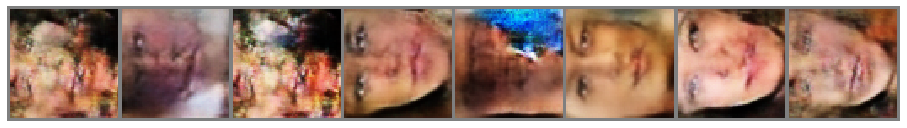

Epoch: 10
Batch:  0
1:Discriminator_Error:  1.6503233909606934  Generator_Error:  0.3471963107585907  Recons_Error:  0.08996599912643433
2:Feature Discriminator Error:  1.3842028379440308 Encoder Error:  0.6957852840423584
3 Discriminator_adv_error 0.3098749816417694 Generator_error:  0.30209270119667053
Batch:  150
1:Discriminator_Error:  1.6323444843292236  Generator_Error:  0.3633940517902374  Recons_Error:  0.09059036523103714
2:Feature Discriminator Error:  1.4001502990722656 Encoder Error:  0.6961197853088379
3 Discriminator_adv_error 0.3079151511192322 Generator_error:  0.3017968237400055
Batch:  300
1:Discriminator_Error:  1.5552985668182373  Generator_Error:  0.39536818861961365  Recons_Error:  0.08195427060127258
2:Feature Discriminator Error:  1.387340784072876 Encoder Error:  0.6983078718185425
3 Discriminator_adv_error 0.3044821321964264 Generator_error:  0.2950224280357361
Batch:  450
1:Discriminator_Error:  1.5186078548431396  Generator_Error:  0.6063485741615295  Recons

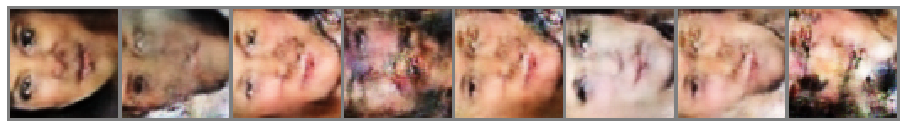

Epoch: 11
Batch:  0
1:Discriminator_Error:  1.5817034244537354  Generator_Error:  0.36230331659317017  Recons_Error:  0.08835487812757492
2:Feature Discriminator Error:  1.389868974685669 Encoder Error:  0.6902282238006592
3 Discriminator_adv_error 0.3169735372066498 Generator_error:  0.30776914954185486
Batch:  150
1:Discriminator_Error:  1.600907802581787  Generator_Error:  0.4025883376598358  Recons_Error:  0.08344621956348419
2:Feature Discriminator Error:  1.3892415761947632 Encoder Error:  0.6908810138702393
3 Discriminator_adv_error 0.3381754457950592 Generator_error:  0.334970623254776
Batch:  300
1:Discriminator_Error:  1.7256269454956055  Generator_Error:  0.3655989170074463  Recons_Error:  0.0839095413684845
2:Feature Discriminator Error:  1.3935165405273438 Encoder Error:  0.6963514089584351
3 Discriminator_adv_error 0.30172276496887207 Generator_error:  0.29123014211654663
Batch:  450
1:Discriminator_Error:  1.5866172313690186  Generator_Error:  0.3856912851333618  Recons_

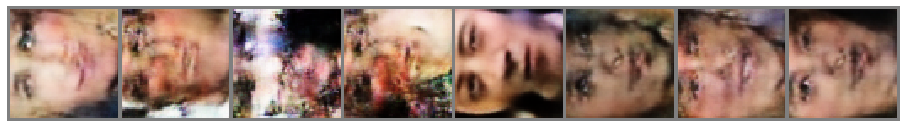

Epoch: 12
Batch:  0
1:Discriminator_Error:  1.6609078645706177  Generator_Error:  0.35023653507232666  Recons_Error:  0.08935984969139099
2:Feature Discriminator Error:  1.381507396697998 Encoder Error:  0.6964586973190308
3 Discriminator_adv_error 0.34228384494781494 Generator_error:  0.3301415741443634
Batch:  150
1:Discriminator_Error:  1.2699042558670044  Generator_Error:  1.20819890499115  Recons_Error:  0.07986372709274292
2:Feature Discriminator Error:  1.38783597946167 Encoder Error:  0.7005460858345032
3 Discriminator_adv_error 0.4663099944591522 Generator_error:  0.3811540901660919
Batch:  300
1:Discriminator_Error:  1.4774470329284668  Generator_Error:  0.402666300535202  Recons_Error:  0.0797358900308609
2:Feature Discriminator Error:  1.383819341659546 Encoder Error:  0.6996703147888184
3 Discriminator_adv_error 0.2631273865699768 Generator_error:  0.25851479172706604
Batch:  450
1:Discriminator_Error:  1.4572999477386475  Generator_Error:  0.4283878207206726  Recons_Error

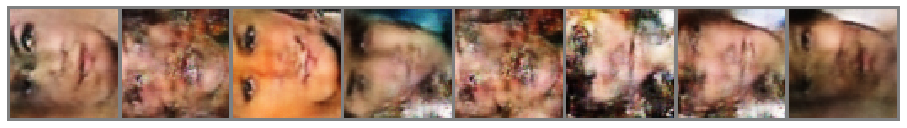

Epoch: 13
Batch:  0
1:Discriminator_Error:  1.6526786088943481  Generator_Error:  0.45327621698379517  Recons_Error:  0.086098313331604
2:Feature Discriminator Error:  1.386748194694519 Encoder Error:  0.6955525875091553
3 Discriminator_adv_error 0.30566489696502686 Generator_error:  0.3025350272655487
Batch:  150
1:Discriminator_Error:  1.6788661479949951  Generator_Error:  0.3907543122768402  Recons_Error:  0.07926435768604279
2:Feature Discriminator Error:  1.3851656913757324 Encoder Error:  0.6946976780891418
3 Discriminator_adv_error 0.3212863802909851 Generator_error:  0.3203297555446625
Batch:  300
1:Discriminator_Error:  1.6539664268493652  Generator_Error:  0.3289748728275299  Recons_Error:  0.07909218966960907
2:Feature Discriminator Error:  1.3920388221740723 Encoder Error:  0.6959676742553711
3 Discriminator_adv_error 0.303886353969574 Generator_error:  0.2943840026855469
Batch:  450
1:Discriminator_Error:  1.6750760078430176  Generator_Error:  0.4070112705230713  Recons_Er

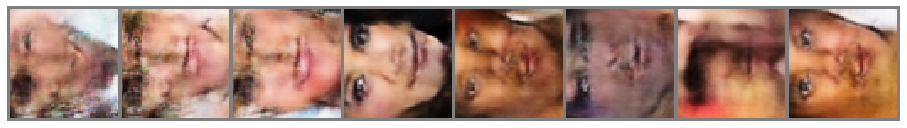

Epoch: 14
Batch:  0
1:Discriminator_Error:  1.5939631462097168  Generator_Error:  0.40698567032814026  Recons_Error:  0.07751026004552841
2:Feature Discriminator Error:  1.3830029964447021 Encoder Error:  0.6889890432357788
3 Discriminator_adv_error 0.3109917938709259 Generator_error:  0.3061862587928772
Batch:  150
1:Discriminator_Error:  1.6154463291168213  Generator_Error:  0.3629308044910431  Recons_Error:  0.07900086790323257
2:Feature Discriminator Error:  1.3921616077423096 Encoder Error:  0.6927026510238647
3 Discriminator_adv_error 0.30684933066368103 Generator_error:  0.30249688029289246
Batch:  300
1:Discriminator_Error:  1.568623661994934  Generator_Error:  0.47439903020858765  Recons_Error:  0.07860536873340607
2:Feature Discriminator Error:  1.3895108699798584 Encoder Error:  0.6945850253105164
3 Discriminator_adv_error 0.342304527759552 Generator_error:  0.3176237940788269
Batch:  450
1:Discriminator_Error:  1.6698176860809326  Generator_Error:  0.3361867666244507  Recon

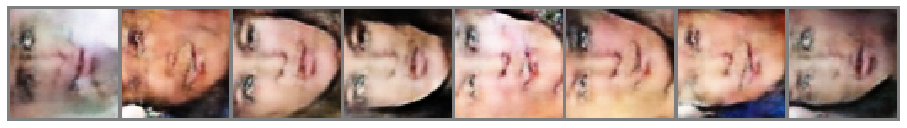

Epoch: 15
Batch:  0
1:Discriminator_Error:  1.6842706203460693  Generator_Error:  0.3390905261039734  Recons_Error:  0.07870233058929443
2:Feature Discriminator Error:  1.3843110799789429 Encoder Error:  0.6885222792625427
3 Discriminator_adv_error 0.31195998191833496 Generator_error:  0.30322951078414917
Batch:  150
1:Discriminator_Error:  1.5373605489730835  Generator_Error:  0.38273149728775024  Recons_Error:  0.07639516144990921
2:Feature Discriminator Error:  1.3830015659332275 Encoder Error:  0.7008448839187622
3 Discriminator_adv_error 0.26610222458839417 Generator_error:  0.2496863454580307
Batch:  300
1:Discriminator_Error:  1.6421818733215332  Generator_Error:  0.4234127402305603  Recons_Error:  0.07575437426567078
2:Feature Discriminator Error:  1.3912463188171387 Encoder Error:  0.6922370195388794
3 Discriminator_adv_error 0.32839199900627136 Generator_error:  0.32113775610923767
Batch:  450
1:Discriminator_Error:  1.6514990329742432  Generator_Error:  0.3348335027694702  R

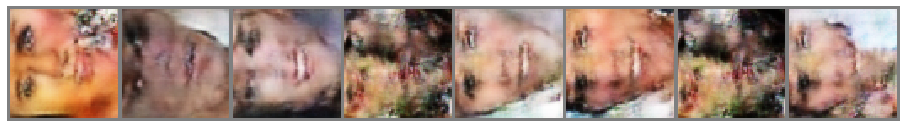

Epoch: 16
Batch:  0
1:Discriminator_Error:  1.5897016525268555  Generator_Error:  0.41493698954582214  Recons_Error:  0.0889570415019989
2:Feature Discriminator Error:  1.3801493644714355 Encoder Error:  0.6924921274185181
3 Discriminator_adv_error 0.3373830318450928 Generator_error:  0.31158608198165894
Batch:  150
1:Discriminator_Error:  1.6195402145385742  Generator_Error:  0.3507097661495209  Recons_Error:  0.0819835290312767
2:Feature Discriminator Error:  1.3821182250976562 Encoder Error:  0.6985645294189453
3 Discriminator_adv_error 0.3040768504142761 Generator_error:  0.2934363782405853
Batch:  300
1:Discriminator_Error:  1.5756866931915283  Generator_Error:  0.4066506624221802  Recons_Error:  0.07863884419202805
2:Feature Discriminator Error:  1.3835407495498657 Encoder Error:  0.6984672546386719
3 Discriminator_adv_error 0.31264960765838623 Generator_error:  0.28930041193962097
Batch:  450
1:Discriminator_Error:  1.6543041467666626  Generator_Error:  0.33554109930992126  Reco

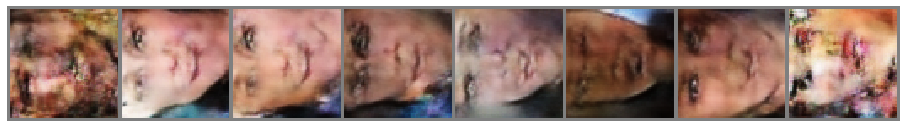

Epoch: 17
Batch:  0
1:Discriminator_Error:  1.6064345836639404  Generator_Error:  0.3774973154067993  Recons_Error:  0.08313260227441788
2:Feature Discriminator Error:  1.390860915184021 Encoder Error:  0.6891291737556458
3 Discriminator_adv_error 0.36154991388320923 Generator_error:  0.3512270450592041
Batch:  150
1:Discriminator_Error:  1.4697790145874023  Generator_Error:  0.4666218161582947  Recons_Error:  0.0831984430551529
2:Feature Discriminator Error:  1.38168203830719 Encoder Error:  0.6968674659729004
3 Discriminator_adv_error 0.3681526482105255 Generator_error:  0.3493460416793823
Batch:  300
1:Discriminator_Error:  1.6565918922424316  Generator_Error:  0.36097395420074463  Recons_Error:  0.07337958365678787
2:Feature Discriminator Error:  1.3842307329177856 Encoder Error:  0.6919578909873962
3 Discriminator_adv_error 0.3371981084346771 Generator_error:  0.3295619487762451
Batch:  450
1:Discriminator_Error:  1.620467185974121  Generator_Error:  0.3699728846549988  Recons_Err

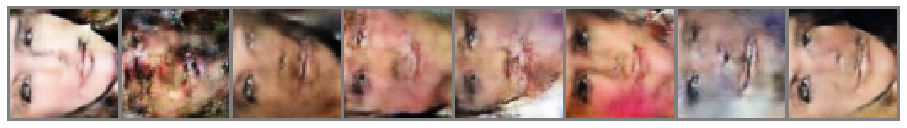

Epoch: 18
Batch:  0
1:Discriminator_Error:  1.6663777828216553  Generator_Error:  0.3726458251476288  Recons_Error:  0.08511429280042648
2:Feature Discriminator Error:  1.3866653442382812 Encoder Error:  0.6963860988616943
3 Discriminator_adv_error 0.3917014002799988 Generator_error:  0.36344802379608154
Batch:  150
1:Discriminator_Error:  1.6622438430786133  Generator_Error:  0.3367113471031189  Recons_Error:  0.08037160336971283
2:Feature Discriminator Error:  1.3923168182373047 Encoder Error:  0.6950035691261292
3 Discriminator_adv_error 0.3105400502681732 Generator_error:  0.30521124601364136
Batch:  300
1:Discriminator_Error:  1.6709150075912476  Generator_Error:  0.37690094113349915  Recons_Error:  0.07711955904960632
2:Feature Discriminator Error:  1.3818424940109253 Encoder Error:  0.6954175233840942
3 Discriminator_adv_error 0.33868151903152466 Generator_error:  0.3106989860534668
Batch:  450
1:Discriminator_Error:  1.6035574674606323  Generator_Error:  0.36515653133392334  Re

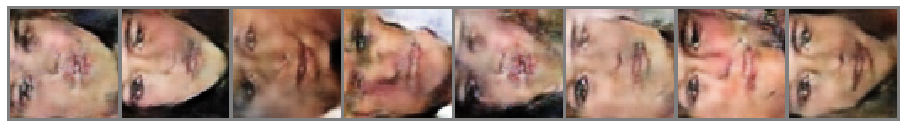

Epoch: 19
Batch:  0
1:Discriminator_Error:  1.5587754249572754  Generator_Error:  0.4027427136898041  Recons_Error:  0.07881450653076172
2:Feature Discriminator Error:  1.3873283863067627 Encoder Error:  0.6960638165473938
3 Discriminator_adv_error 0.3371323347091675 Generator_error:  0.3223990201950073
Batch:  150
1:Discriminator_Error:  1.6757850646972656  Generator_Error:  0.3435680866241455  Recons_Error:  0.07189500331878662
2:Feature Discriminator Error:  1.3906712532043457 Encoder Error:  0.6941090822219849
3 Discriminator_adv_error 0.35068705677986145 Generator_error:  0.3360138237476349
Batch:  300
1:Discriminator_Error:  1.6288808584213257  Generator_Error:  0.3702360987663269  Recons_Error:  0.07520274817943573
2:Feature Discriminator Error:  1.3918476104736328 Encoder Error:  0.691115140914917
3 Discriminator_adv_error 0.29538413882255554 Generator_error:  0.2882176339626312
Batch:  450
1:Discriminator_Error:  1.6564900875091553  Generator_Error:  0.33480656147003174  Recon

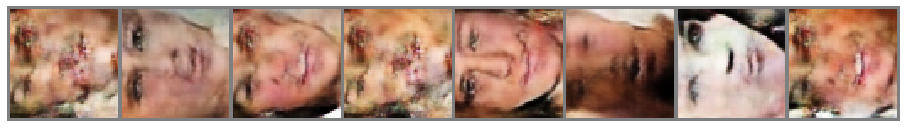

Epoch: 20
Batch:  0
1:Discriminator_Error:  1.51080322265625  Generator_Error:  0.46599942445755005  Recons_Error:  0.08215153962373734
2:Feature Discriminator Error:  1.3889219760894775 Encoder Error:  0.6816898584365845
3 Discriminator_adv_error 0.33396807312965393 Generator_error:  0.32337793707847595
Batch:  150
1:Discriminator_Error:  1.5886814594268799  Generator_Error:  0.40019163489341736  Recons_Error:  0.07450520247220993
2:Feature Discriminator Error:  1.3961613178253174 Encoder Error:  0.6974096894264221
3 Discriminator_adv_error 0.3401474058628082 Generator_error:  0.32566016912460327
Batch:  300
1:Discriminator_Error:  1.6438391208648682  Generator_Error:  0.32818305492401123  Recons_Error:  0.07465128600597382
2:Feature Discriminator Error:  1.393233299255371 Encoder Error:  0.6984179615974426
3 Discriminator_adv_error 0.30183395743370056 Generator_error:  0.2982841432094574
Batch:  450
1:Discriminator_Error:  1.6340718269348145  Generator_Error:  0.33891570568084717  Re

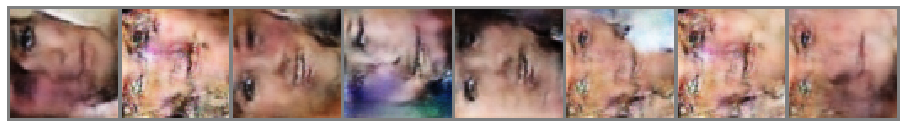

Epoch: 21
Batch:  0
1:Discriminator_Error:  1.642896294593811  Generator_Error:  0.35461896657943726  Recons_Error:  0.08131708949804306
2:Feature Discriminator Error:  1.3914226293563843 Encoder Error:  0.6929740905761719
3 Discriminator_adv_error 0.3653883635997772 Generator_error:  0.3508824110031128
Batch:  150
1:Discriminator_Error:  1.6413500308990479  Generator_Error:  0.3496531546115875  Recons_Error:  0.0770326778292656
2:Feature Discriminator Error:  1.388608455657959 Encoder Error:  0.7008625268936157
3 Discriminator_adv_error 0.33680710196495056 Generator_error:  0.32728806138038635
Batch:  300
1:Discriminator_Error:  1.6723493337631226  Generator_Error:  0.32490473985671997  Recons_Error:  0.07861723005771637
2:Feature Discriminator Error:  1.3794665336608887 Encoder Error:  0.6976959705352783
3 Discriminator_adv_error 0.30417659878730774 Generator_error:  0.3018319010734558
Batch:  450
1:Discriminator_Error:  1.7903285026550293  Generator_Error:  0.3044584393501282  Recon

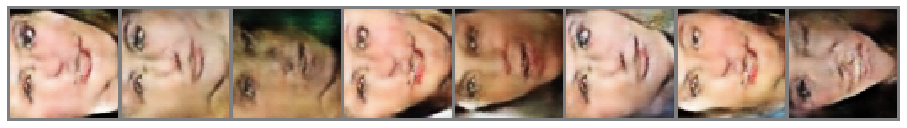

Epoch: 22
Batch:  0
1:Discriminator_Error:  1.6594181060791016  Generator_Error:  0.32803431153297424  Recons_Error:  0.07853633165359497
2:Feature Discriminator Error:  1.384884238243103 Encoder Error:  0.6924430131912231
3 Discriminator_adv_error 0.3266708254814148 Generator_error:  0.3201829195022583
Batch:  150
1:Discriminator_Error:  1.6416882276535034  Generator_Error:  0.3377179205417633  Recons_Error:  0.07616574317216873
2:Feature Discriminator Error:  1.3835573196411133 Encoder Error:  0.6946628093719482
3 Discriminator_adv_error 0.3054700195789337 Generator_error:  0.29478463530540466
Batch:  300
1:Discriminator_Error:  1.5881953239440918  Generator_Error:  0.3528882563114166  Recons_Error:  0.07732705026865005
2:Feature Discriminator Error:  1.3846745491027832 Encoder Error:  0.6857505440711975
3 Discriminator_adv_error 0.300468385219574 Generator_error:  0.2942202091217041
Batch:  450
1:Discriminator_Error:  1.6466436386108398  Generator_Error:  0.3643036484718323  Recons_

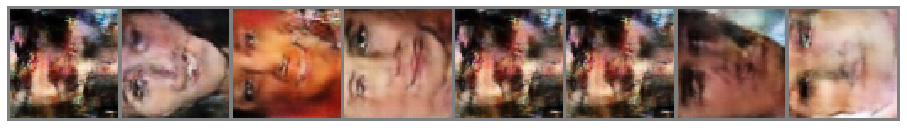

Epoch: 23
Batch:  0
1:Discriminator_Error:  1.6316323280334473  Generator_Error:  0.43223854899406433  Recons_Error:  0.07524549961090088
2:Feature Discriminator Error:  1.3891122341156006 Encoder Error:  0.6981759667396545
3 Discriminator_adv_error 0.36839935183525085 Generator_error:  0.3460805416107178
Batch:  150
1:Discriminator_Error:  1.6932361125946045  Generator_Error:  0.33901330828666687  Recons_Error:  0.07979070395231247
2:Feature Discriminator Error:  1.3857725858688354 Encoder Error:  0.6918997764587402
3 Discriminator_adv_error 0.3427915871143341 Generator_error:  0.33607402443885803
Batch:  300
1:Discriminator_Error:  1.7189221382141113  Generator_Error:  0.31865808367729187  Recons_Error:  0.07537750154733658
2:Feature Discriminator Error:  1.3821501731872559 Encoder Error:  0.6935919523239136
3 Discriminator_adv_error 0.3334553837776184 Generator_error:  0.3279447853565216
Batch:  450
1:Discriminator_Error:  1.7262622117996216  Generator_Error:  0.31612899899482727  R

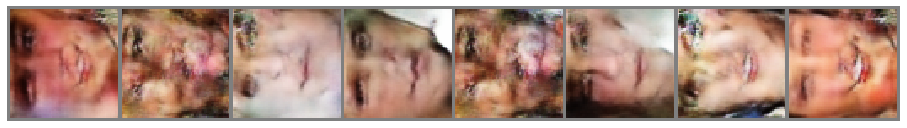

Epoch: 24
Batch:  0
1:Discriminator_Error:  1.4509449005126953  Generator_Error:  0.4835801124572754  Recons_Error:  0.08042667806148529
2:Feature Discriminator Error:  1.387993335723877 Encoder Error:  0.6919487714767456
3 Discriminator_adv_error 0.3474958837032318 Generator_error:  0.31420662999153137
Batch:  150
1:Discriminator_Error:  1.6825683116912842  Generator_Error:  0.5007238984107971  Recons_Error:  0.07517051696777344
2:Feature Discriminator Error:  1.383157730102539 Encoder Error:  0.69321608543396
3 Discriminator_adv_error 0.31208834052085876 Generator_error:  0.3061564862728119
Batch:  300
1:Discriminator_Error:  1.7078877687454224  Generator_Error:  0.3182224631309509  Recons_Error:  0.07474508136510849
2:Feature Discriminator Error:  1.3961882591247559 Encoder Error:  0.6988627910614014
3 Discriminator_adv_error 0.315874308347702 Generator_error:  0.31290072202682495
Batch:  450
1:Discriminator_Error:  1.6948761940002441  Generator_Error:  0.3078501224517822  Recons_Er

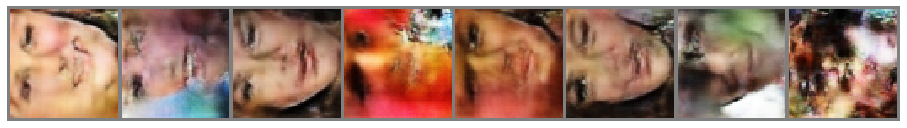

Epoch: 25
Batch:  0
1:Discriminator_Error:  1.6363424062728882  Generator_Error:  0.3342733681201935  Recons_Error:  0.07616078853607178
2:Feature Discriminator Error:  1.386404275894165 Encoder Error:  0.6937730312347412
3 Discriminator_adv_error 0.2954636812210083 Generator_error:  0.2944819927215576
Batch:  150
1:Discriminator_Error:  1.638138771057129  Generator_Error:  0.3354269564151764  Recons_Error:  0.07469486445188522
2:Feature Discriminator Error:  1.388117790222168 Encoder Error:  0.6973333358764648
3 Discriminator_adv_error 0.27322936058044434 Generator_error:  0.2699435353279114
Batch:  300
1:Discriminator_Error:  1.7140073776245117  Generator_Error:  0.3231447637081146  Recons_Error:  0.07839363068342209
2:Feature Discriminator Error:  1.3928766250610352 Encoder Error:  0.6879494786262512
3 Discriminator_adv_error 0.34741178154945374 Generator_error:  0.3286193609237671
Batch:  450
1:Discriminator_Error:  1.6931076049804688  Generator_Error:  0.3658773899078369  Recons_E

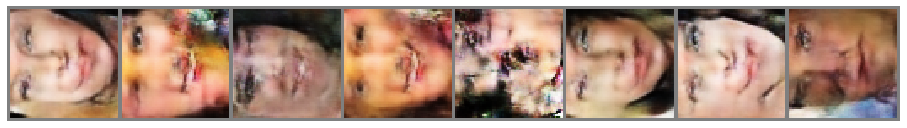

Epoch: 26
Batch:  0
1:Discriminator_Error:  1.6353302001953125  Generator_Error:  0.32543283700942993  Recons_Error:  0.07918481528759003
2:Feature Discriminator Error:  1.377511978149414 Encoder Error:  0.6905508041381836
3 Discriminator_adv_error 0.2925044596195221 Generator_error:  0.28649118542671204
Batch:  150
1:Discriminator_Error:  1.6934343576431274  Generator_Error:  0.3058062791824341  Recons_Error:  0.07754457741975784
2:Feature Discriminator Error:  1.3812834024429321 Encoder Error:  0.6915946006774902
3 Discriminator_adv_error 0.2936108112335205 Generator_error:  0.286687433719635
Batch:  300
1:Discriminator_Error:  1.6290549039840698  Generator_Error:  0.32107359170913696  Recons_Error:  0.07368288189172745
2:Feature Discriminator Error:  1.3840183019638062 Encoder Error:  0.7034792900085449
3 Discriminator_adv_error 0.27327585220336914 Generator_error:  0.2717446982860565
Batch:  450
1:Discriminator_Error:  1.5798343420028687  Generator_Error:  0.37838104367256165  Reco

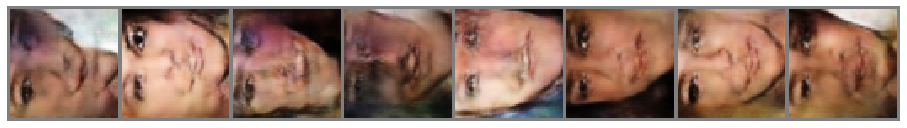

Epoch: 27
Batch:  0
1:Discriminator_Error:  1.6784467697143555  Generator_Error:  0.3278125822544098  Recons_Error:  0.10499509423971176
2:Feature Discriminator Error:  1.3935227394104004 Encoder Error:  0.6906396746635437
3 Discriminator_adv_error 0.33276912569999695 Generator_error:  0.3162845969200134
Batch:  150
1:Discriminator_Error:  1.6946460008621216  Generator_Error:  0.32555922865867615  Recons_Error:  0.07662059366703033
2:Feature Discriminator Error:  1.3861315250396729 Encoder Error:  0.6912858486175537
3 Discriminator_adv_error 0.34580525755882263 Generator_error:  0.3349563181400299
Batch:  300
1:Discriminator_Error:  1.7947558164596558  Generator_Error:  0.2988423705101013  Recons_Error:  0.07733936607837677
2:Feature Discriminator Error:  1.385661005973816 Encoder Error:  0.6927833557128906
3 Discriminator_adv_error 0.31544721126556396 Generator_error:  0.2995510697364807
Batch:  450
1:Discriminator_Error:  1.6174862384796143  Generator_Error:  0.3287190794944763  Reco

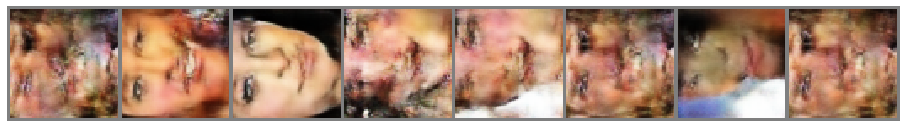

Epoch: 28
Batch:  0
1:Discriminator_Error:  1.6508705615997314  Generator_Error:  0.33605116605758667  Recons_Error:  0.08040102571249008
2:Feature Discriminator Error:  1.396000623703003 Encoder Error:  0.6942682266235352
3 Discriminator_adv_error 0.3452704846858978 Generator_error:  0.3115634024143219
Batch:  150
1:Discriminator_Error:  1.7100591659545898  Generator_Error:  0.3183409571647644  Recons_Error:  0.07558099925518036
2:Feature Discriminator Error:  1.3848782777786255 Encoder Error:  0.6967602968215942
3 Discriminator_adv_error 0.3348272740840912 Generator_error:  0.3219049870967865
Batch:  300
1:Discriminator_Error:  1.6149358749389648  Generator_Error:  0.33953312039375305  Recons_Error:  0.07259367406368256
2:Feature Discriminator Error:  1.386580467224121 Encoder Error:  0.697765052318573
3 Discriminator_adv_error 0.2750348448753357 Generator_error:  0.266625314950943
Batch:  450
1:Discriminator_Error:  1.676503300666809  Generator_Error:  0.3122064471244812  Recons_Err

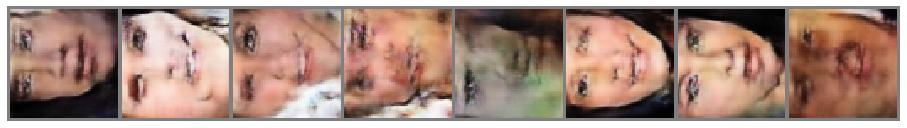

Epoch: 29
Batch:  0
1:Discriminator_Error:  1.622955322265625  Generator_Error:  0.3519912362098694  Recons_Error:  0.07287560403347015
2:Feature Discriminator Error:  1.3883507251739502 Encoder Error:  0.6928898096084595
3 Discriminator_adv_error 0.3121000826358795 Generator_error:  0.30238068103790283
Batch:  150
1:Discriminator_Error:  1.6387814283370972  Generator_Error:  0.33798083662986755  Recons_Error:  0.07626712322235107
2:Feature Discriminator Error:  1.3942270278930664 Encoder Error:  0.6925241947174072
3 Discriminator_adv_error 0.31255781650543213 Generator_error:  0.30726808309555054
Batch:  300
1:Discriminator_Error:  1.693102240562439  Generator_Error:  0.3276359736919403  Recons_Error:  0.07313916832208633
2:Feature Discriminator Error:  1.3825206756591797 Encoder Error:  0.6941847801208496
3 Discriminator_adv_error 0.34560316801071167 Generator_error:  0.3320388197898865
Batch:  450
1:Discriminator_Error:  1.6715238094329834  Generator_Error:  0.311869740486145  Recon

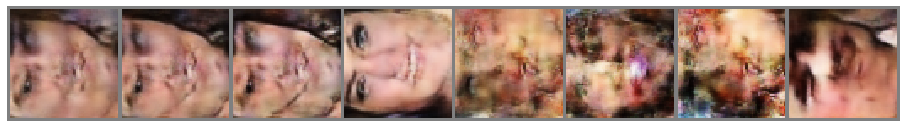

Epoch: 30
Batch:  0
1:Discriminator_Error:  1.687272071838379  Generator_Error:  0.3105638921260834  Recons_Error:  0.08004598319530487
2:Feature Discriminator Error:  1.3783891201019287 Encoder Error:  0.6980849504470825
3 Discriminator_adv_error 0.29849231243133545 Generator_error:  0.2966102957725525
Batch:  150
1:Discriminator_Error:  1.7171211242675781  Generator_Error:  0.30085045099258423  Recons_Error:  0.07748010009527206
2:Feature Discriminator Error:  1.391075849533081 Encoder Error:  0.6935727596282959
3 Discriminator_adv_error 0.3097166121006012 Generator_error:  0.3068763315677643
Batch:  300
1:Discriminator_Error:  1.6041315793991089  Generator_Error:  0.377655565738678  Recons_Error:  0.07382235676050186
2:Feature Discriminator Error:  1.3853551149368286 Encoder Error:  0.6902691721916199
3 Discriminator_adv_error 0.33548828959465027 Generator_error:  0.3291403651237488
Batch:  450
1:Discriminator_Error:  1.6305317878723145  Generator_Error:  0.3261113464832306  Recons_

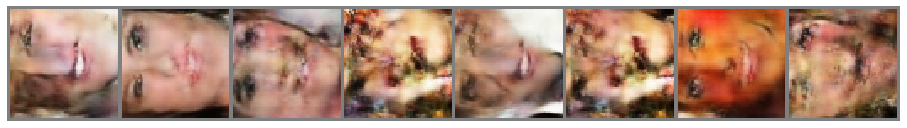

Epoch: 31
Batch:  0
1:Discriminator_Error:  1.6950840950012207  Generator_Error:  0.3029744029045105  Recons_Error:  0.07035823166370392
2:Feature Discriminator Error:  1.3953869342803955 Encoder Error:  0.6890686750411987
3 Discriminator_adv_error 0.2981778085231781 Generator_error:  0.2955726087093353
Batch:  150
1:Discriminator_Error:  1.6011154651641846  Generator_Error:  0.39638641476631165  Recons_Error:  0.07491905242204666
2:Feature Discriminator Error:  1.3832547664642334 Encoder Error:  0.6976926326751709
3 Discriminator_adv_error 0.2707672417163849 Generator_error:  0.27319520711898804
Batch:  300
1:Discriminator_Error:  1.8611624240875244  Generator_Error:  0.27804994583129883  Recons_Error:  0.0707070454955101
2:Feature Discriminator Error:  1.3823051452636719 Encoder Error:  0.6912896633148193
3 Discriminator_adv_error 0.29835379123687744 Generator_error:  0.29701370000839233
Batch:  450
1:Discriminator_Error:  1.6518068313598633  Generator_Error:  0.33274298906326294  Re

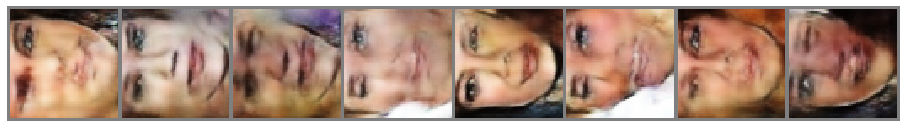

Epoch: 32
Batch:  0
1:Discriminator_Error:  1.6316157579421997  Generator_Error:  0.3750320374965668  Recons_Error:  0.07685250043869019
2:Feature Discriminator Error:  1.3807308673858643 Encoder Error:  0.6930702924728394
3 Discriminator_adv_error 0.388571172952652 Generator_error:  0.3564140498638153
Batch:  150
1:Discriminator_Error:  1.661373496055603  Generator_Error:  0.3238851726055145  Recons_Error:  0.06768921762704849
2:Feature Discriminator Error:  1.3825687170028687 Encoder Error:  0.6911303997039795
3 Discriminator_adv_error 0.2917111814022064 Generator_error:  0.2881357669830322
Batch:  300
1:Discriminator_Error:  1.6569998264312744  Generator_Error:  0.30841413140296936  Recons_Error:  0.07118827849626541
2:Feature Discriminator Error:  1.39481782913208 Encoder Error:  0.6890209317207336
3 Discriminator_adv_error 0.2708246409893036 Generator_error:  0.2669222056865692
Batch:  450
1:Discriminator_Error:  1.6187644004821777  Generator_Error:  0.3314546048641205  Recons_Err

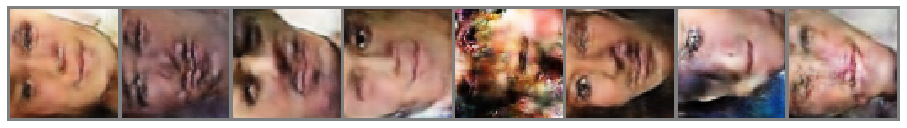

Epoch: 33
Batch:  0
1:Discriminator_Error:  1.6875487565994263  Generator_Error:  0.31849682331085205  Recons_Error:  0.07395141571760178
2:Feature Discriminator Error:  1.3915901184082031 Encoder Error:  0.6938043832778931
3 Discriminator_adv_error 0.3272532820701599 Generator_error:  0.31118789315223694
Batch:  150
1:Discriminator_Error:  1.4960826635360718  Generator_Error:  0.4581291377544403  Recons_Error:  0.07226891815662384
2:Feature Discriminator Error:  1.3812988996505737 Encoder Error:  0.6906496286392212
3 Discriminator_adv_error 0.3446395695209503 Generator_error:  0.31863656640052795
Batch:  300
1:Discriminator_Error:  1.6392416954040527  Generator_Error:  0.31540119647979736  Recons_Error:  0.07337097078561783
2:Feature Discriminator Error:  1.3818950653076172 Encoder Error:  0.6975330710411072
3 Discriminator_adv_error 0.26822614669799805 Generator_error:  0.25781962275505066
Batch:  450
1:Discriminator_Error:  1.6468008756637573  Generator_Error:  0.32704299688339233  

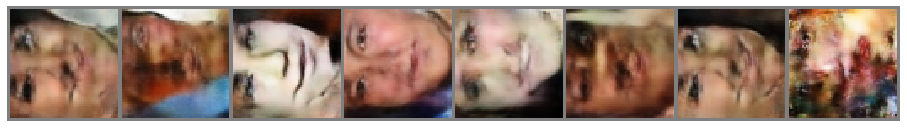

Epoch: 34
Batch:  0
1:Discriminator_Error:  1.6894985437393188  Generator_Error:  0.31779250502586365  Recons_Error:  0.08134085685014725
2:Feature Discriminator Error:  1.3837692737579346 Encoder Error:  0.6986549496650696
3 Discriminator_adv_error 0.29833951592445374 Generator_error:  0.2957010567188263
Batch:  150
1:Discriminator_Error:  1.7282912731170654  Generator_Error:  0.29546740651130676  Recons_Error:  0.07078391313552856
2:Feature Discriminator Error:  1.3939526081085205 Encoder Error:  0.7025532722473145
3 Discriminator_adv_error 0.2881597876548767 Generator_error:  0.2839823365211487
Batch:  300
1:Discriminator_Error:  1.6374142169952393  Generator_Error:  0.3221859037876129  Recons_Error:  0.07372903823852539
2:Feature Discriminator Error:  1.3907448053359985 Encoder Error:  0.6995368003845215
3 Discriminator_adv_error 0.2871952950954437 Generator_error:  0.2832917869091034
Batch:  450
1:Discriminator_Error:  1.6353853940963745  Generator_Error:  0.3264273405075073  Reco

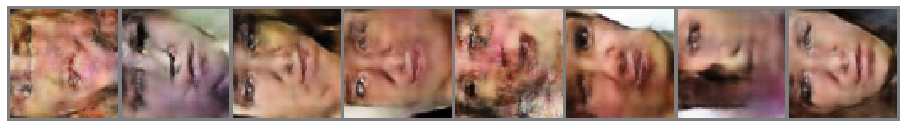

Epoch: 35
Batch:  0
1:Discriminator_Error:  1.6930688619613647  Generator_Error:  0.34212374687194824  Recons_Error:  0.07389737665653229
2:Feature Discriminator Error:  1.3871022462844849 Encoder Error:  0.693235456943512
3 Discriminator_adv_error 0.32399651408195496 Generator_error:  0.3229638338088989
Batch:  150
1:Discriminator_Error:  1.7208267450332642  Generator_Error:  0.2904607057571411  Recons_Error:  0.06866708397865295
2:Feature Discriminator Error:  1.3930838108062744 Encoder Error:  0.6909397840499878
3 Discriminator_adv_error 0.2717624604701996 Generator_error:  0.26733115315437317
Batch:  300
1:Discriminator_Error:  1.6748371124267578  Generator_Error:  0.3067965805530548  Recons_Error:  0.07004925608634949
2:Feature Discriminator Error:  1.3924193382263184 Encoder Error:  0.6932631731033325
3 Discriminator_adv_error 0.30501043796539307 Generator_error:  0.2975902557373047
Batch:  450
1:Discriminator_Error:  1.656816005706787  Generator_Error:  0.3616279363632202  Recon

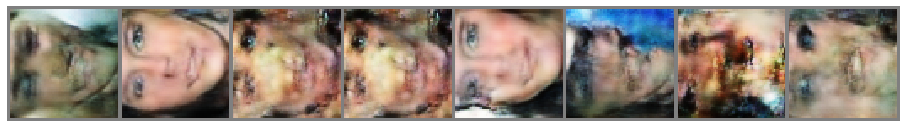

Epoch: 36
Batch:  0
1:Discriminator_Error:  1.2871057987213135  Generator_Error:  0.540671706199646  Recons_Error:  0.08503499627113342
2:Feature Discriminator Error:  1.3797295093536377 Encoder Error:  0.6954780220985413
3 Discriminator_adv_error 0.27946507930755615 Generator_error:  0.2680701017379761
Batch:  150
1:Discriminator_Error:  1.6835803985595703  Generator_Error:  0.32136279344558716  Recons_Error:  0.06926139444112778
2:Feature Discriminator Error:  1.380401611328125 Encoder Error:  0.6881698369979858
3 Discriminator_adv_error 0.32015836238861084 Generator_error:  0.30413928627967834
Batch:  300
1:Discriminator_Error:  1.6721200942993164  Generator_Error:  0.31113922595977783  Recons_Error:  0.07290107011795044
2:Feature Discriminator Error:  1.3813984394073486 Encoder Error:  0.6902215480804443
3 Discriminator_adv_error 0.2873728275299072 Generator_error:  0.28528040647506714
Batch:  450
1:Discriminator_Error:  1.6769342422485352  Generator_Error:  0.3205747604370117  Rec

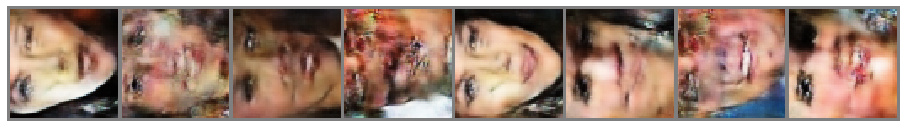

Epoch: 37
Batch:  0
1:Discriminator_Error:  1.6236720085144043  Generator_Error:  0.3456331789493561  Recons_Error:  0.07644890993833542
2:Feature Discriminator Error:  1.3854258060455322 Encoder Error:  0.6932108998298645
3 Discriminator_adv_error 0.3225889503955841 Generator_error:  0.3100474178791046
Batch:  150
1:Discriminator_Error:  1.71808660030365  Generator_Error:  0.29151707887649536  Recons_Error:  0.07112137228250504
2:Feature Discriminator Error:  1.386002779006958 Encoder Error:  0.6866717338562012
3 Discriminator_adv_error 0.2941453456878662 Generator_error:  0.2765401601791382
Batch:  300
1:Discriminator_Error:  1.6727361679077148  Generator_Error:  0.3102613091468811  Recons_Error:  0.07205382734537125
2:Feature Discriminator Error:  1.379239797592163 Encoder Error:  0.6958706974983215
3 Discriminator_adv_error 0.2842848598957062 Generator_error:  0.28262341022491455
Batch:  450
1:Discriminator_Error:  1.7546979188919067  Generator_Error:  0.2972044348716736  Recons_Er

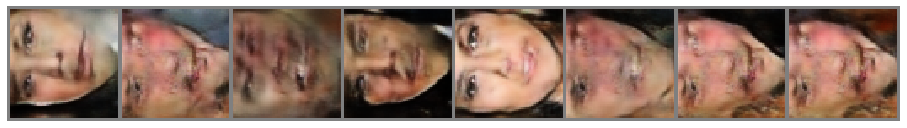

Epoch: 38
Batch:  0
1:Discriminator_Error:  1.647085428237915  Generator_Error:  0.33801376819610596  Recons_Error:  0.07204306125640869
2:Feature Discriminator Error:  1.3883845806121826 Encoder Error:  0.6972240209579468
3 Discriminator_adv_error 0.29196247458457947 Generator_error:  0.2915739119052887
Batch:  150
1:Discriminator_Error:  1.703126311302185  Generator_Error:  0.3126825988292694  Recons_Error:  0.07951324433088303
2:Feature Discriminator Error:  1.3770147562026978 Encoder Error:  0.6956580877304077
3 Discriminator_adv_error 0.3015110492706299 Generator_error:  0.2999802529811859
Batch:  300
1:Discriminator_Error:  1.713154911994934  Generator_Error:  0.30224302411079407  Recons_Error:  0.0696239247918129
2:Feature Discriminator Error:  1.3970015048980713 Encoder Error:  0.69610196352005
3 Discriminator_adv_error 0.3012472093105316 Generator_error:  0.29785284399986267
Batch:  450
1:Discriminator_Error:  1.5840215682983398  Generator_Error:  0.3511037230491638  Recons_Er

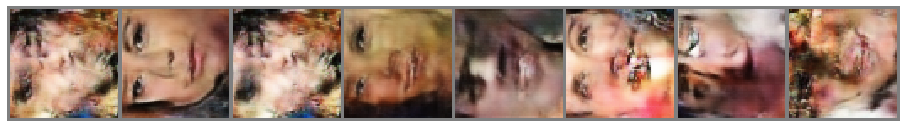

Epoch: 39
Batch:  0
1:Discriminator_Error:  1.4749243259429932  Generator_Error:  0.43865111470222473  Recons_Error:  0.07865077257156372
2:Feature Discriminator Error:  1.3909677267074585 Encoder Error:  0.6934865713119507
3 Discriminator_adv_error 0.3293758034706116 Generator_error:  0.3180893659591675
Batch:  150
1:Discriminator_Error:  1.660622477531433  Generator_Error:  0.31635260581970215  Recons_Error:  0.07067674398422241
2:Feature Discriminator Error:  1.386014461517334 Encoder Error:  0.6900108456611633
3 Discriminator_adv_error 0.3003464937210083 Generator_error:  0.29162532091140747
Batch:  300
1:Discriminator_Error:  1.6910425424575806  Generator_Error:  0.3147691488265991  Recons_Error:  0.07152802497148514
2:Feature Discriminator Error:  1.3796792030334473 Encoder Error:  0.6998414397239685
3 Discriminator_adv_error 0.3472650647163391 Generator_error:  0.3331226110458374
Batch:  450
1:Discriminator_Error:  1.6704156398773193  Generator_Error:  0.30142539739608765  Recon

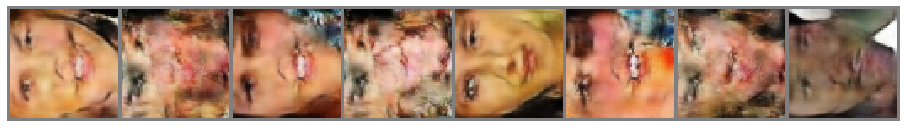

In [30]:
train(40,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load)

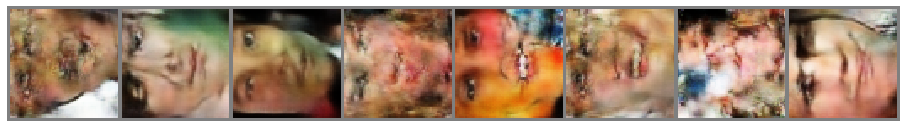

In [32]:
torch.save(Encoder,'Encoder_64batch.h')
torch.save(Decoder,'Decoder_64batch.h')
torch.save(Discriminator_feature,'Discriminator_feature_64batch.h')
torch.save(Discriminator_reconstruct,'Discriminator_reconstruct_64batch.h')
eval_generate(Decoder,8)
        